In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pyh5md
import scipy.integrate
from scipy.optimize import leastsq
from glob import glob
import itertools
import tidynamics
import datetime
from matplotlib.figure import SubplotParams
import mpl_toolkits.mplot3d

plt.rcParams['figure.figsize'] = (8*.7, 3.5)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .2
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 16

π = np.pi
    
def read_data(group):
    """Read correlation stored using logarithmically spaced blocks as
    stored by RMPCDMD."""
    value = group['value'][:]
    count = group['count'][:]
    value /= count.reshape((-1, 1, 1, 1))
    tau = group['time'][()]
    return value, count, tau

def get_block_data(block, dt):
    """Return an array for the successive times of the block correlator
    and a concatenated array with the correlation value."""
    t_data = []
    data = []
    for i in range(block.shape[0]):
        t = np.arange(block.shape[1])*block.shape[1]**i
        t_data.append(t[1:])
        data.append(block[i,1:,:,:].reshape((-1,3)))

    return np.concatenate(t_data)*dt, np.concatenate(data)

def expfitfunc(p, t):
    """Exponential fitting function"""
    #f0 = p[0]
    f0 = 1
    tau = p[0]
    return f0*np.exp(-t/tau)

def experrfunc(p, t, y):
    return (expfitfunc(p, t)-y)

summary = ''

In [2]:
# Collect simulation data
EPSB = '10.00'

summary += 'Results for EPSB={}\n\n'.format(EPSB)

runs = glob('/path/to/active/janus/with/{EPSB}/janus.h5'.format(EPSB=EPSB))

runs.sort()

store = {}

print(len(runs), "runs found")

12 runs found


In [3]:
# Collect simulation data
eq_runs = glob('/path/to/equilibrium/janus/with/{EPSB}/janus.h5'.format(EPSB='01.00'))

eq_runs.sort()

print(len(eq_runs), "runs found")

24 runs found


In [4]:
store[EPSB] = []
for r in runs:
    data = {}
    with pyh5md.File(r, 'r') as a:
        L = a['particles/janus/box/edges'][:]
        obs = a['observables']
        janus = a['particles/janus']
        el = pyh5md.element(obs, 'janus_pos')
        com_pos = el.value[:]
        data['com_pos'] = com_pos
        data['com_pos_dt'] = el.time
        el = pyh5md.element(obs, 'janus_vel')
        com_vel = el.value[:]
        data['com_vel'] = com_vel
        data['com_vel_dt'] = el.time
        el = pyh5md.element(obs, 'u')
        u = el.value[:]
        data['u'] = u
        data['u_dt'] = el.time
        el = pyh5md.element(obs, 'omega_body')
        omega_body = el.value[:]
        data['omega_body'] = omega_body
        data['omega_body_dt'] = el.time
        del el
        vacf, vacf_count, vacf_tau = read_data(a['block_correlators/velocity_autocorrelation'])
        block_t, block_vacf = get_block_data(vacf, vacf_tau)
        data['block_vacf'] = block_vacf
        data['block_vacf_time'] = block_t
        wacf, wacf_count, wacf_tau = read_data(a['block_correlators/omega_body_autocorrelation'])
        block_t, block_wacf = get_block_data(wacf, wacf_tau)
        data['block_wacf'] = block_wacf
        data['block_wacf_time'] = block_t
        oacf, oacf_count, oacf_tau = read_data(a['block_correlators/orientation_autocorrelation'])
        block_t, block_oacf = get_block_data(oacf, oacf_tau)
        data['block_oacf'] = block_oacf
        data['block_oacf_time'] = block_t
    store[EPSB].append(data)


<IPython.core.display.Javascript object>


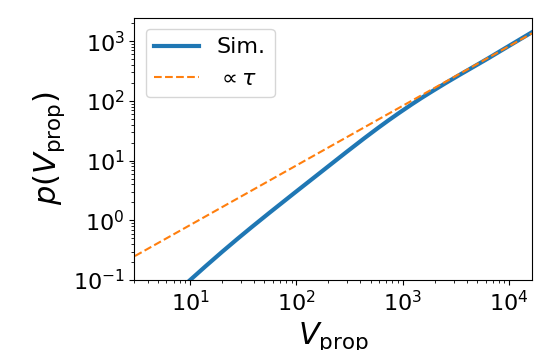

Fitted value for the diffusion coefficient 0.0138523741058


In [5]:
# plot msd

plt.figure()

count = 0

N_SKIP = 8

N_msd_time = store[EPSB][0]['com_pos'].shape[0]//(N_SKIP*4)

msd_t = np.arange(N_msd_time)*store[EPSB][0]['com_pos_dt']*N_SKIP

rsq_data = np.array([tidynamics.msd(data['com_pos'][::N_SKIP])[:N_msd_time] for data in store[EPSB]])

plt.plot(msd_t, rsq_data.mean(axis=0), label='Sim.', lw=3)

mask = (msd_t>3000) * (msd_t<5000)

fit = np.polyfit(msd_t[mask], rsq_data.mean(axis=0)[mask], 1)

print('Fitted value for the diffusion coefficient', fit[0]/6)

summary += "Diffusion coefficient (fit from MSD): {}\n".format(fit[0]/6)

plt.plot(msd_t, msd_t*fit[0], ls='--', label=r'$\propto \tau$')

plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'MSD$(\tau)$', fontsize=22)
plt.loglog()
plt.legend()
plt.xlim(3, 2*8192)
plt.ylim(0.1, 2500)
plt.savefig('active_janus_{EPSB}_msd.pdf'.format(EPSB=EPSB))

In [6]:
# plot velocity distribution

N_vel_time = store[EPSB][0]['com_vel'].shape[0]

vel_t = np.arange(N_vel_time)*store[EPSB][0]['com_vel_dt']

speed = [np.sum(data['com_vel']*data['u'], axis=1) for data in store[EPSB]]

print(np.mean(speed, axis=1))

plt.hist(speed[0], bins=32, normed=True, histtype='step');
plt.axvline(speed[0].mean(), lw=3);

plt.xlabel(r'$V_\mathrm{prop}$')
plt.ylabel(r'$p(V_\mathrm{prop})$')
plt.savefig('active_janus_{EPSB}_directed_v.pdf'.format(EPSB=EPSB))

[-0.00989169 -0.0106784  -0.00922748 -0.00950148 -0.00946771 -0.00934123
 -0.00968799 -0.00999378 -0.01017326 -0.0096941  -0.0096644  -0.00957032]


In [7]:
print("Mean self-propelled velocity", np.mean(speed))
summary += "Mean self-propelled velocity: {}\n".format(np.mean(speed))

Mean self-propelled velocity -0.00974098669949


<IPython.core.display.Javascript object>


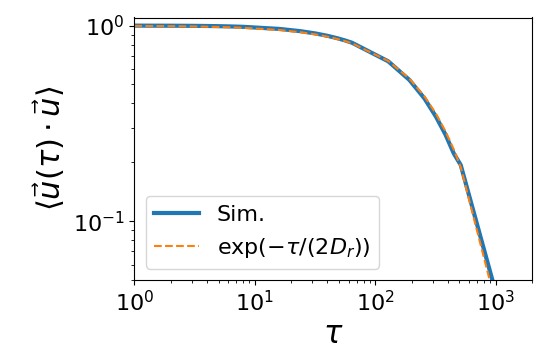

In [8]:
# plot orientation autocorrelation

plt.figure()

block_oacf = np.array([data['block_oacf'].sum(axis=-1) for data in store[EPSB]])
block_e = np.std(block_oacf, axis=0)
block_oacf = np.mean(block_oacf, axis=0)

block_t = store[EPSB][0]['block_oacf_time']

mask = block_t < 300
solution, ierr = leastsq(experrfunc, [10], args=(block_t[mask], block_oacf[mask]))

plt.plot(block_t, block_oacf, lw=3, label='Sim.')

plt.plot(block_t, expfitfunc(solution, block_t), ls='--', label=r'$\exp(-\tau/(2 D_r))$')


plt.legend()


plt.xlim(1, 2000)
plt.ylim(0.05, 1.1)
plt.loglog()

plt.xlabel(r'$\tau$', fontsize=22)
plt.ylabel(r'$\langle \vec u(\tau)\cdot \vec u \rangle$', fontsize=22);

plt.savefig('active_janus_{EPSB}_oacf.pdf'.format(EPSB=EPSB))

In [9]:
print("Rotational time", solution[0])
print("Rotational diffusion coefficient", 1/(2*solution[0]))
summary += """Rotational time {}
Rotational diffusion coefficient {}""".format(solution[0], 1/(2*solution[0]))

Rotational time 307.308903451
Rotational diffusion coefficient 0.00162702737989


In [10]:
print(summary)

Results for EPSB=10.00

Diffusion coefficient (fit from MSD): 0.01385237410580452
Mean self-propelled velocity: -0.009740986699486198
Rotational time 307.3089034508784
Rotational diffusion coefficient 0.001627027379894713


<IPython.core.display.Javascript object>


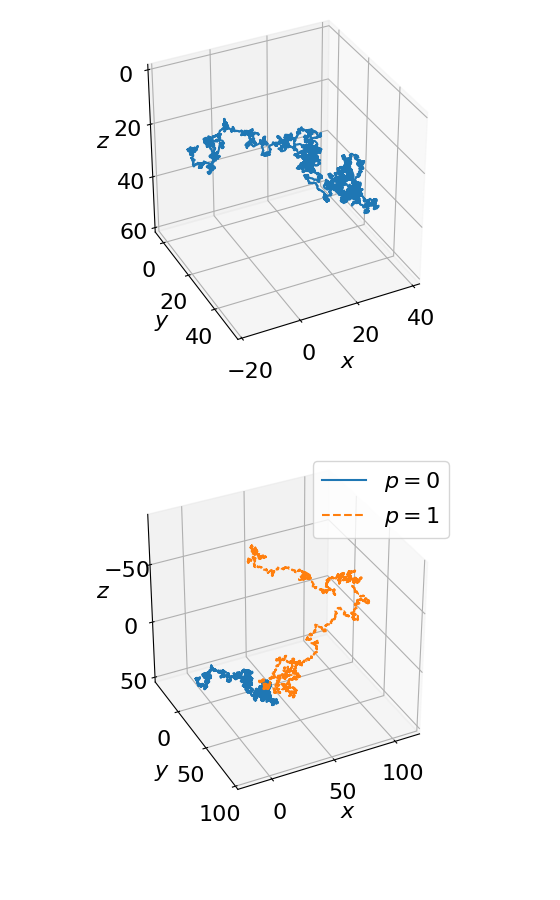

In [11]:
# plot equilibrium and self-propelled example trajectories

params = SubplotParams(left=0., bottom=0.1, right=1, top=1)
fig = plt.figure(figsize=(5.6, 9), subplotpars=params)

with pyh5md.File(runs[1], 'r') as a:
    obs = a['observables']
    sp_pos = pyh5md.element(obs, 'janus_pos').value[::4]

with pyh5md.File(eq_runs[4] ,'r') as a:
    obs = a['observables']
    eq_pos = pyh5md.element(obs, 'janus_pos').value[::4]

ax1 = plt.subplot(211, projection='3d', aspect=1)

ax1.plot(*eq_pos[::4,:].T)
ax1.view_init(-146.68125000000094, -63.543750000000841)

ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_zlabel(r'$z$')

x1, x2 = ax1.get_xlim()
deltax = x2-x1
y1, y2 = ax1.get_ylim()
deltay = y2-y1
z1, z2 = ax1.get_zlim()
deltaz = z2-z1
deltamax = max(deltax, deltay, deltaz)
ax1.set_xlim((x1+x2)/2 - deltamax/2, (x1+x2)/2 + deltamax/2)
ax1.set_ylim((y1+y2)/2 - deltamax/2, (y1+y2)/2 + deltamax/2)
ax1.set_zlim((z1+z2)/2 - deltamax/2, (z1+z2)/2 + deltamax/2)

ax2 = plt.subplot(212, projection='3d', aspect=1)

ax2.plot(*eq_pos[::4,:].T, label='$p=0$')
ax2.plot(*sp_pos[::4,:].T, ls='--', label='$p=1$')
ax2.view_init(-146.68125000000094, -63.543750000000841)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')
ax2.set_zlabel(r'$z$')

x1, x2 = ax2.get_xlim()
deltax = x2-x1
y1, y2 = ax2.get_ylim()
deltay = y2-y1
z1, z2 = ax2.get_zlim()
deltaz = z2-z1
deltamax = max(deltax, deltay, deltaz)
ax2.set_xlim((x1+x2)/2 - deltamax/2, (x1+x2)/2 + deltamax/2)
ax2.set_ylim((y1+y2)/2 - deltamax/2, (y1+y2)/2 + deltamax/2)
ax2.set_zlim((z1+z2)/2 - deltamax/2, (z1+z2)/2 + deltamax/2)

plt.legend()

def on_move(event):
    if event.inaxes == ax1:
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
    else:
        return
    fig.canvas.draw_idle()

c1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

fig.canvas.draw_idle()

plt.savefig('janus_example_trajectories.pdf')
